In [1]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.duplicate import ElementwiseDuplicateElimination
from pymoo.optimize import minimize
from jobshop.params import JobShopRandomParams, JobShopParams
from jobshop.heurstic.decoder import Decoder
from jobshop.heurstic.brkga import BRKGA

In [2]:
params = JobShopRandomParams(10, 10, t_span=(0, 20), seed=12)  # 10, 10 seed 12 known optimal solution 153

In [3]:
class JobShopProblem(ElementwiseProblem):
    
    def __init__(self, params: JobShopParams):
        self.params = params
        n_var = 0
        for j, machines in self.params.seq.items():
            n_var = n_var + len(machines)
        xl = np.zeros(n_var)
        xu = np.ones(n_var)
        self.decoder = Decoder(
            self.params.machines, self.params.jobs,
            self.params.p_times, self.params.seq
        )
        super().__init__(elementwise=True, n_var=n_var, n_obj=1, xl=xl, xu=xu)
    
    def _evaluate(self, x, out, *args, **kwargs):
        z, C = self.decoder.decode(x)
        out["pheno"] = z
        out["hash"] = hash(str(z))
        out["F"] = C

In [4]:
class DuplicatesEncoder(ElementwiseDuplicateElimination):
    
    def __init__(self, x_tol=1e-3) -> None:
        super().__init__()
        self.x_tol = x_tol

    def is_equal(self, a, b):
        same_pheno = a.get("hash") == b.get("hash")
        diff_x = a.get("X") - b.get("X")
        dist_x = np.sqrt(diff_x.dot(diff_x))
        return same_pheno and dist_x <= self.x_tol * len(diff_x)

In [5]:
brkga = BRKGA(
    pop_size=100,
    perc_elite=0.15,
    perc_mutants=0.15,
    bias=0.8,
    eliminate_duplicates=DuplicatesEncoder(1e-5),
)
problem = JobShopProblem(params)

In [6]:
res = minimize(problem, brkga, ("n_gen", 200), verbose=True, seed=12)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |      100 |  2.741500E+02 |  2.160000E+02
     2 |      185 |  2.635800E+02 |  2.040000E+02
     3 |      270 |  2.572600E+02 |  2.040000E+02
     4 |      355 |  2.549800E+02 |  1.950000E+02
     5 |      440 |  2.533900E+02 |  1.950000E+02
     6 |      525 |  2.541400E+02 |  1.950000E+02
     7 |      610 |  2.517600E+02 |  1.950000E+02
     8 |      695 |  2.523000E+02 |  1.950000E+02
     9 |      780 |  2.497000E+02 |  1.950000E+02
    10 |      865 |  2.509200E+02 |  1.950000E+02
    11 |      950 |  2.523500E+02 |  1.920000E+02
    12 |     1035 |  2.523200E+02 |  1.920000E+02
    13 |     1120 |  2.495200E+02 |  1.920000E+02
    14 |     1205 |  2.482400E+02 |  1.920000E+02
    15 |     1290 |  2.506800E+02 |  1.920000E+02
    16 |     1375 |  2.506500E+02 |  1.920000E+02
    17 |     1460 |  2.483000E+02 |  1.920000E+02
    18 |     1545 |  2.466900E+02 |  1.920000E+02
    19 |     1630 |  2.426300E+02 |  1.920000E+02


In [7]:
graph = problem.decoder.build_graph_from_string(res.X)

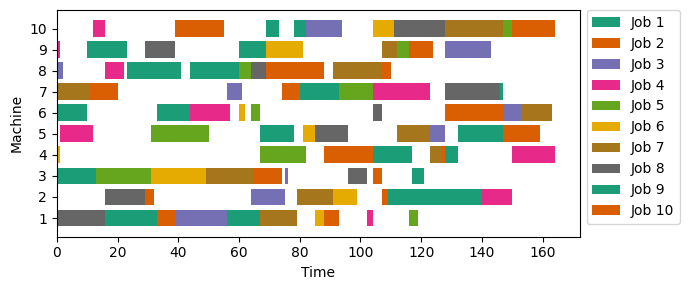

In [8]:
graph.plot()